# Harmonic Oscillator GENERIC Dynamics

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lawrennd/the-inaccessible-game/blob/main/mass-spring-simulation-example.ipynb)

Demonstrates constrained information dynamics for a harmonic oscillator using the GENERIC decomposition M = S + A.


In [1]:
# Setup cell for Google Colab compatibility
import sys
import os

# Check if we're running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Running in Google Colab - setting up environment...")
    
    # Clone the repository if not already present
    if not os.path.exists('the-inaccessible-game'):
        !git clone https://github.com/lawrennd/the-inaccessible-game.git
        print("✓ Repository cloned")

    # Change to repo directory
    os.chdir('the-inaccessible-game')

    # Install dependencies
    !pip install -q numpy scipy matplotlib
    print("✓ Dependencies installed")
    
    # Add repo to Python path so we can import modules
    if os.getcwd() not in sys.path:
        sys.path.insert(0, os.getcwd())
    
    print("✓ Setup complete! You can now run the notebook.")
else:
    print("💻 Running locally - no setup needed")


💻 Running locally - no setup needed


In [2]:
"""
Harmonic Oscillator GENERIC Dynamics with Thermalisation
=========================================================

Demonstrates constrained information dynamics for a harmonic oscillator
using the GENERIC decomposition M = S + A.

The system evolves in natural parameter space (θ_xx, θ_pp, θ_xp) under:
- Constraint: h(X) + h(P) = C (sum of marginal entropies)
- Dynamics: dθ/dt = -G(θ)θ + ν(θ)a(θ)

At thermal equilibrium, this yields:
- A (antisymmetric): Hamiltonian oscillations
- S (symmetric): Thermalisation toward equilibrium
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, det

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid' if 'seaborn-v0_8-whitegrid' in plt.style.available else 'default')
big_wide_figsize = (10, 5)
big_figsize = (8, 8)
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 'medium',
})

In [4]:
# Physical parameters
k = 1.0      # Spring constant
m = 1.0      # Mass
T = 1.0      # Temperature
k_B = 1.0    # Boltzmann constant
beta = 1.0 / (k_B * T)

# Equilibrium covariances from statistical mechanics
sigma_x_eq = k_B * T / k      # = 1.0
sigma_p_eq = m * k_B * T      # = 1.0

print("=== Harmonic Oscillator GENERIC Dynamics ===")
print(f"Physical parameters: k={k}, m={m}, T={T}")
print(f"Equilibrium: σ_x² = {sigma_x_eq:.3f}, σ_p² = {sigma_p_eq:.3f}")
print()

=== Harmonic Oscillator GENERIC Dynamics ===
Physical parameters: k=1.0, m=1.0, T=1.0
Equilibrium: σ_x² = 1.000, σ_p² = 1.000



In [5]:
from harmonic_oscillator import *

In [6]:
# Initial condition: AWAY from thermal equilibrium
# Start with cold x, hot p (violates equipartition)
theta_init = np.array([2.0 * beta * k,    # Cold x: small variance
                       0.5 * beta / m,     # Hot p: large variance  
                       0.0])               # No correlation
#theta_init = np.array([beta * k, beta / m, 0.5])  # Strong positive correlation

#c = 0.3  # Factor of 3 more energy
#theta_init = np.array([c * beta * k, c * beta / m, 0.0])

# Start very far from equilibrium
theta_init = np.array([5.0 * beta * k,   # Very cold x (small σ_x²)
                       0.2 * beta / m,    # Very hot p (large σ_p²)
                       0.5])              # Add correlation

print("Initial state:")
h_X, h_P, h_total = marginal_entropies(theta_init)
print(f"  h(X) = {h_X:.3f}, h(P) = {h_P:.3f}, h(X)+h(P) = {h_total:.3f}")

Sigma_init = precision_to_covariance(theta_init)
print(f"  σ_x² = {Sigma_init[0,0]:.3f} (eq: {sigma_x_eq:.3f})")
print(f"  σ_p² = {Sigma_init[1,1]:.3f} (eq: {sigma_p_eq:.3f})")
print()

# Equilibrium state
theta_eq = np.array([beta * k, beta / m, 0.0])
print("Equilibrium state:")
h_X_eq, h_P_eq, h_total_eq = marginal_entropies(theta_eq)
print(f"  h(X) = {h_X_eq:.3f}, h(P) = {h_P_eq:.3f}, h(X)+h(P) = {h_total_eq:.3f}")
print()

# Analyze GENERIC decomposition at equilibrium
print("GENERIC decomposition at equilibrium:")
M_eq = compute_jacobian_numerical(theta_eq)
if M_eq is not None:
    S_eq = 0.5 * (M_eq + M_eq.T)
    A_eq = 0.5 * (M_eq - M_eq.T)
    
    norm_S = np.linalg.norm(S_eq, 'fro')
    norm_A = np.linalg.norm(A_eq, 'fro')
    ratio = norm_A / norm_S if norm_S > 1e-10 else np.inf
    
    print(f"  ||S|| = {norm_S:.6f} (dissipative)")
    print(f"  ||A|| = {norm_A:.6f} (conservative)")
    print(f"  ||A||/||S|| = {ratio:.3f}")
    print()

# Run simulation
print("Running simulation...")
tau_span = 5.0
dtau = 0.001
taus, trajectory, constraint_vals = simulate_dynamics(theta_init, tau_span, dtau)
print(f"Simulated {len(taus)} steps")
print()

# Extract observables
sigma_x_traj = np.array([precision_to_covariance(theta)[0,0] if precision_to_covariance(theta) is not None else np.nan 
                         for theta in trajectory])
sigma_p_traj = np.array([precision_to_covariance(theta)[1,1] if precision_to_covariance(theta) is not None else np.nan
                         for theta in trajectory])

# Create figure
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

Initial state:
  h(X) = 0.758, h(P) = 2.367, h(X)+h(P) = 3.126
  σ_x² = 0.267 (eq: 1.000)
  σ_p² = 6.667 (eq: 1.000)

Equilibrium state:
  h(X) = 1.419, h(P) = 1.419, h(X)+h(P) = 2.838

GENERIC decomposition at equilibrium:
  ||S|| = 1.000000 (dissipative)
  ||A|| = 0.000020 (conservative)
  ||A||/||S|| = 0.000

Running simulation...
Simulated 5000 steps



<Figure size 1500x1000 with 0 Axes>

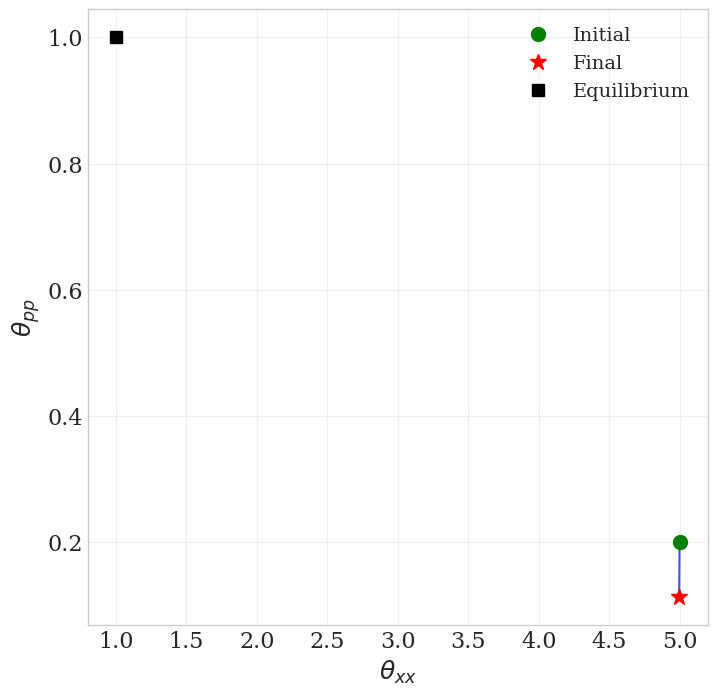

In [7]:
# 1. Trajectory in parameter space
fig, ax = plt.subplots(figsize=big_figsize)
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=1.5, alpha=0.7)
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, label='Initial')
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=12, label='Final')
ax.plot(theta_eq[0], theta_eq[1], 'ks', markersize=8, label='Equilibrium')
ax.set_xlabel(r'$\theta_{xx}$')
ax.set_ylabel(r'$\theta_{pp}$')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig_harmonic-oscillator_trajectory-in-parameter-space.pdf', 
            bbox_inches='tight', dpi=300)

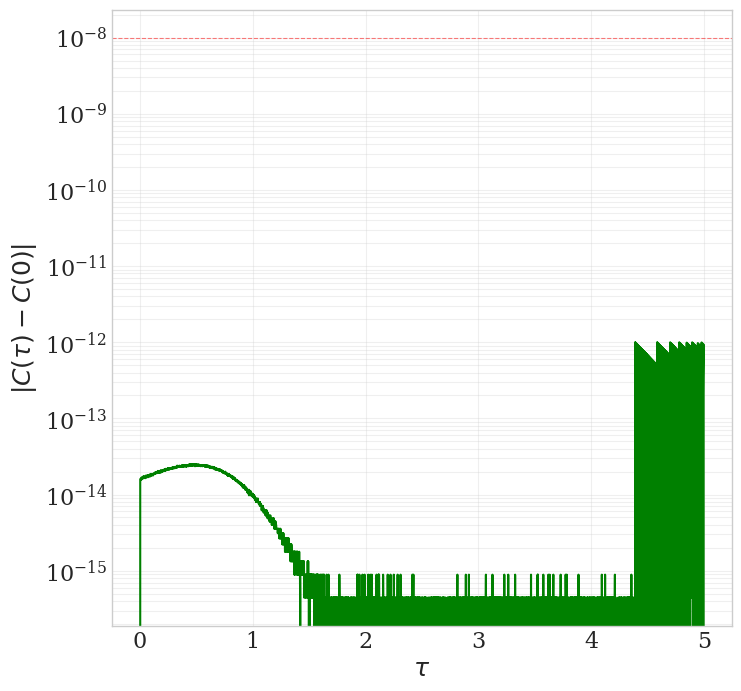

In [8]:
# 2. Constraint preservation
fig, ax = plt.subplots(figsize=big_figsize)
constraint_deviation = np.abs(constraint_vals - constraint_vals[0])
ax.semilogy(taus, constraint_deviation, 'g-', linewidth=1.5)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$|C(\tau) - C(0)|$')
ax.grid(True, alpha=0.3, which='both')
ax.axhline(1e-8, color='r', linestyle='--', linewidth=0.8, alpha=0.5)
plt.savefig('./diagrams/fig_harmonic-oscillator_constraint-preservation.pdf', 
            bbox_inches='tight', dpi=300)

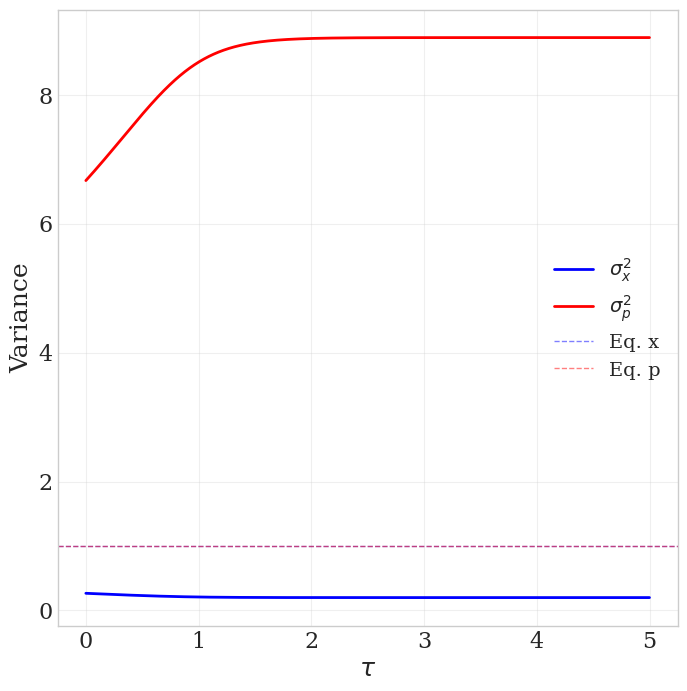

In [9]:
# 3. Variances evolution (thermalisation)
fig, ax = plt.subplots(figsize=big_figsize)
ax.plot(taus, sigma_x_traj, 'b-', linewidth=2, label=r'$\sigma_x^2$')
ax.plot(taus, sigma_p_traj, 'r-', linewidth=2, label=r'$\sigma_p^2$')
ax.axhline(sigma_x_eq, color='b', linestyle='--', linewidth=1, alpha=0.5, label='Eq. x')
ax.axhline(sigma_p_eq, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Eq. p')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Variance')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig_harmonic-oscillator_variances-evolution.pdf', 
            bbox_inches='tight', dpi=300)

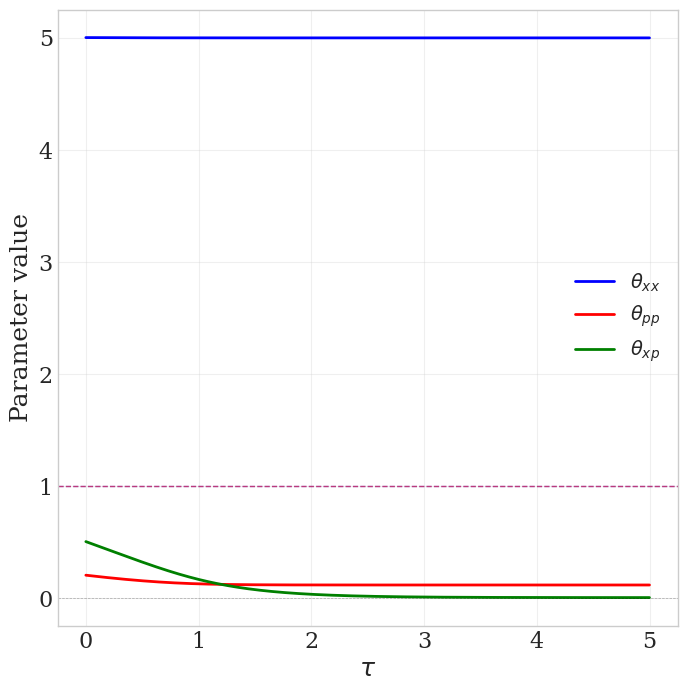

In [10]:
# 4. Natural parameters evolution
fig, ax = plt.subplots(figsize=big_figsize)
ax.plot(taus, trajectory[:, 0], 'b-', linewidth=2, label=r'$\theta_{xx}$')
ax.plot(taus, trajectory[:, 1], 'r-', linewidth=2, label=r'$\theta_{pp}$')
ax.plot(taus, trajectory[:, 2], 'g-', linewidth=2, label=r'$\theta_{xp}$')
ax.axhline(theta_eq[0], color='b', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(theta_eq[1], color='r', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5, alpha=0.3)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Parameter value')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig_harmonic-oscillator_natural-parameters-evolution.pdf', 
            bbox_inches='tight', dpi=300)

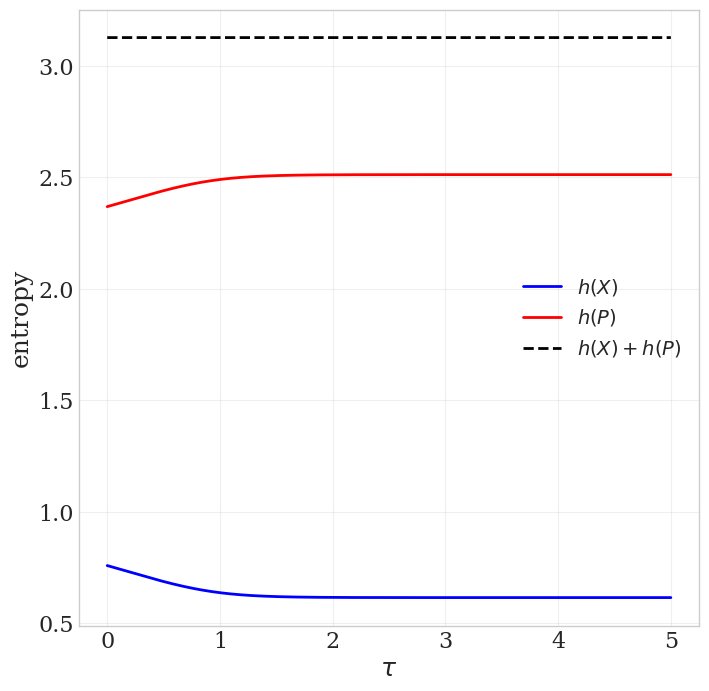

In [11]:
# 5. Marginal entropies
fig, ax = plt.subplots(figsize=big_figsize)
h_X_traj = [marginal_entropies(theta)[0] for theta in trajectory]
h_P_traj = [marginal_entropies(theta)[1] for theta in trajectory]
ax.plot(taus, h_X_traj, 'b-', linewidth=2, label=r'$h(X)$')
ax.plot(taus, h_P_traj, 'r-', linewidth=2, label=r'$h(P)$')
ax.plot(taus, np.array(h_X_traj) + np.array(h_P_traj), 'k--', 
         linewidth=2, label=r'$h(X) + h(P)$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('entropy')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig_harmonic-oscillator_marginal-entropies.pdf', 
            bbox_inches='tight', dpi=300)

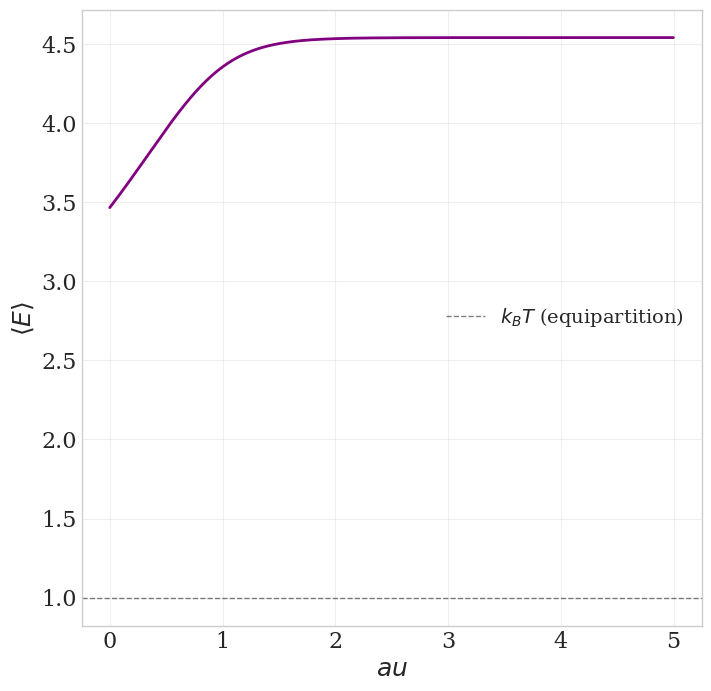

In [12]:
# 6. Energy approximation
fig, ax = plt.subplots(figsize=big_figsize)
# E ≈ (k/2)σ_x² + (1/2m)σ_p²
E_traj = 0.5 * k * sigma_x_traj + 0.5 * (1/m) * sigma_p_traj
ax.plot(taus, E_traj, 'purple', linewidth=2)
ax.axhline(k_B * T, color='k', linestyle='--', linewidth=1, 
            alpha=0.5, label=r'$k_B T$ (equipartition)')
ax.set_xlabel('$\tau$')
ax.set_ylabel(r'$\langle E \rangle$')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig_harmonic-oscillator_energy-approximation.pdf', 
            bbox_inches='tight', dpi=300)

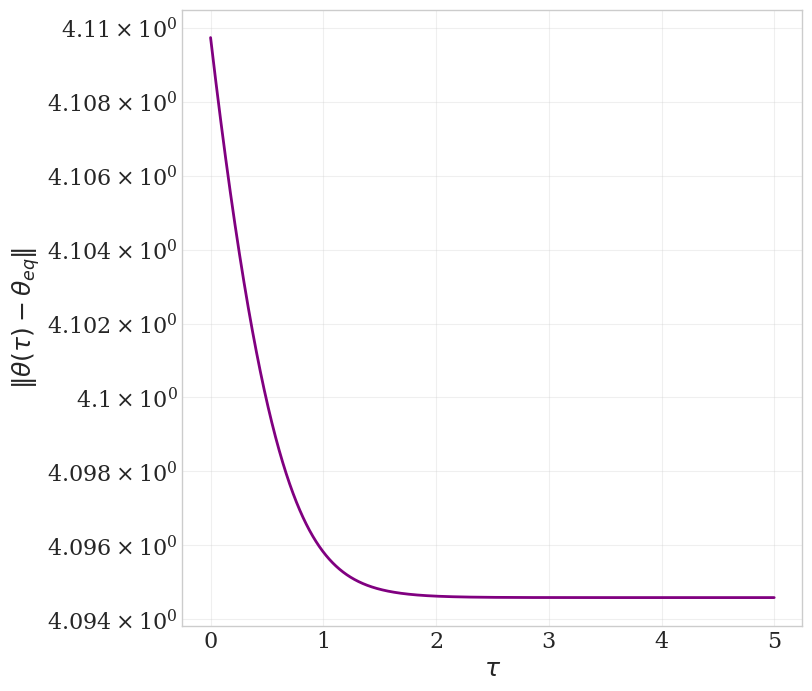

In [13]:
# 8. Distance to equilibrium
fig, ax = plt.subplots(figsize=big_figsize)
dist_to_eq = np.linalg.norm(trajectory - theta_eq, axis=1)
ax.semilogy(taus, dist_to_eq, 'purple', linewidth=2)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\|\theta(\tau) - \theta_{eq}\|$')
ax.grid(True, alpha=0.3, which='both')
plt.savefig('./diagrams/fig_harmonic-oscillator_distance-to-equilibrium.pdf', 
            bbox_inches='tight', dpi=300)


In [14]:

print(
    r"$\mathbf{GENERIC\ Structure}$" + "\n\n"
    f"Initial: σ_x² = {Sigma_init[0,0]:.2f}, σ_p² = {Sigma_init[1,1]:.2f}\n"
    f"Final:   σ_x² = {sigma_x_traj[-1]:.2f}, σ_p² = {sigma_p_traj[-1]:.2f}\n"
    f"Equilib: σ_x² = {sigma_x_eq:.2f}, σ_p² = {sigma_p_eq:.2f}\n\n"
    "Constraint preserved:\n"
    f"  |ΔC| < {constraint_deviation[-1]:.2e}\n\n"
    "Thermalisation:\n"
    "  System relaxes to equipartition\n"
    "  through symmetric part S\n\n"
    "Conservation:\n"
    "  h(X) + h(P) = const\n"
    "  implies β⟨E⟩ = const\n"
    "  (energy conserved via A)")


$\mathbf{GENERIC\ Structure}$

Initial: σ_x² = 0.27, σ_p² = 6.67
Final:   σ_x² = 0.20, σ_p² = 8.88
Equilib: σ_x² = 1.00, σ_p² = 1.00

Constraint preserved:
  |ΔC| < 0.00e+00

Thermalisation:
  System relaxes to equipartition
  through symmetric part S

Conservation:
  h(X) + h(P) = const
  implies β⟨E⟩ = const
  (energy conserved via A)


In [15]:
"""
Particle Trajectories under Evolving Distribution
==================================================

This code runs AFTER the harmonic oscillator GENERIC simulation.
It takes the evolving distribution θ(t) and simulates particle trajectories
under the linearised dynamics at each time step.

As the distribution thermalises, the effective Hamiltonian changes,
affecting the particle oscillation frequencies.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Ellipse

print("\n=== Particle Trajectories with Thermalization ===")

# Number of particles to track
n_particles = 20

# Sample initial conditions from initial distribution
Sigma_init = precision_to_covariance(trajectory[0])
mean_init = np.array([0.0, 0.0])

print(f"Sampling {n_particles} particles from initial distribution")
print(f"Initial covariance:\n{Sigma_init}")

# Sample particles
np.random.seed(24)
particles_init = np.random.multivariate_normal(mean_init, Sigma_init, n_particles)
print(f"Sample ranges: x ∈ [{particles_init[:,0].min():.2f}, {particles_init[:,0].max():.2f}], "
      f"p ∈ [{particles_init[:,1].min():.2f}, {particles_init[:,1].max():.2f}]")

# Store particle trajectories
particle_trajectories = np.zeros((len(taus), n_particles, 2))
particle_trajectories[0] = particles_init

# Store effective parameters at each timestep
k_eff_traj = np.zeros(len(taus))
m_eff_traj = np.zeros(len(taus))
omega_traj = np.zeros(len(taus))

print("\nEvolving particles under time-varying linearised dynamics...")

# Evolve particles
for i in range(len(taus) - 1):
    # Get current covariance
    Sigma_t = precision_to_covariance(trajectory[i])
    sigma_x_sq = Sigma_t[0, 0]
    sigma_p_sq = Sigma_t[1, 1]
    
    # Effective parameters from distribution
    # For Gaussian with covariance Σ, the "spring constant" and "mass" are:
    # k_eff = k_B T / σ_x²  (stiffer spring when σ_x² is small)
    # m_eff = σ_p² / k_B T  (heavier mass when σ_p² is large)
    
    k_eff = k_B * T / sigma_x_sq
    m_eff = sigma_p_sq / (k_B * T)
    omega = np.sqrt(k_eff / m_eff)
    
    k_eff_traj[i] = k_eff
    m_eff_traj[i] = m_eff
    omega_traj[i] = omega
    
    # Current particles
    x_curr = particle_trajectories[i, :, 0]
    p_curr = particle_trajectories[i, :, 1]
    
    # Linearised Hamiltonian dynamics
    # dx/dtau = p / m_eff
    # dp/dtau = -k_eff * x
    
    dx_dtau = p_curr / m_eff
    dp_dtau = -k_eff * x_curr
    
    # Euler step (same dtau as distribution dynamics)
    x_next = x_curr + dtau * dx_dtau
    p_next = p_curr + dtau * dp_dtau
    
    particle_trajectories[i+1, :, 0] = x_next
    particle_trajectories[i+1, :, 1] = p_next

# Fill in last effective parameters
Sigma_final = precision_to_covariance(trajectory[-1])
k_eff_traj[-1] = k_B * T / Sigma_final[0, 0]
m_eff_traj[-1] = Sigma_final[1, 1] / (k_B * T)
omega_traj[-1] = np.sqrt(k_eff_traj[-1] / m_eff_traj[-1])

print(f"✓ Computed {len(taus)} tausteps of particle evolution")
print(f"\nEffective parameters:")
print(f"  Initial: k_eff={k_eff_traj[0]:.3f}, m_eff={m_eff_traj[0]:.3f}, ω={omega_traj[0]:.3f}")
print(f"  Final:   k_eff={k_eff_traj[-1]:.3f}, m_eff={m_eff_traj[-1]:.3f}, ω={omega_traj[-1]:.3f}")
print(f"  Equilib: k_eff={k:.3f}, m_eff={m:.3f}, ω={np.sqrt(k/m):.3f}")

# Compute particle energies
particle_energies = 0.5 * k_eff_traj[:, np.newaxis] * particle_trajectories[:, :, 0]**2 + \
                    0.5 * particle_trajectories[:, :, 1]**2 / m_eff_traj[:, np.newaxis]




=== Particle Trajectories with Thermalization ===
Sampling 20 particles from initial distribution
Initial covariance:
[[ 0.26666667 -0.66666667]
 [-0.66666667  6.66666667]]
Sample ranges: x ∈ [-1.30, 0.72], p ∈ [-4.19, 4.29]

Evolving particles under time-varying linearised dynamics...
✓ Computed 5000 tausteps of particle evolution

Effective parameters:
  Initial: k_eff=3.750, m_eff=6.667, ω=0.750
  Final:   k_eff=4.997, m_eff=8.884, ω=0.750
  Equilib: k_eff=1.000, m_eff=1.000, ω=1.000


Phase Space: Early $\tau$ ($\tau$ < 1.0)


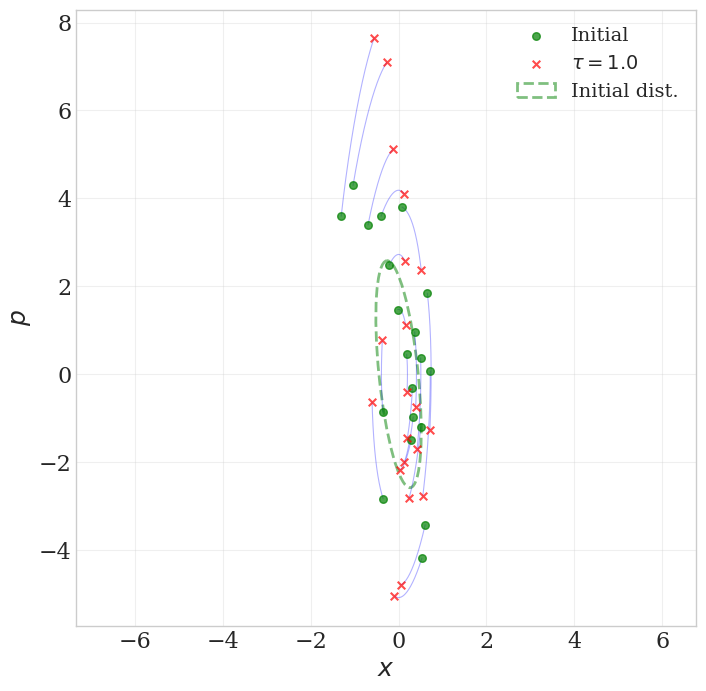

In [16]:
# 1. Phase space trajectories (early time)
fig, ax = plt.subplots(figsize=big_figsize)
tau_early_idx = min(int(0.2 * len(taus)), len(taus)-1)
for i in range(n_particles):
    ax.plot(particle_trajectories[:tau_early_idx, i, 0], 
             particle_trajectories[:tau_early_idx, i, 1], 
             'b-', alpha=0.3, linewidth=0.8)
ax.scatter(particle_trajectories[0, :, 0], particle_trajectories[0, :, 1], 
           c='green', s=30, zorder=5, label='Initial', alpha=0.7)
ax.scatter(particle_trajectories[tau_early_idx, :, 0], particle_trajectories[tau_early_idx, :, 1],
           c='red', s=30, zorder=5, marker='x', label=rf'$\tau={taus[tau_early_idx]:.1f}$', alpha=0.7)

# Add distribution ellipse at start
Sigma_0 = precision_to_covariance(trajectory[0])
lambda_0, v_0 = np.linalg.eig(Sigma_0)
angle_0 = np.arctan2(v_0[1, 0], v_0[0, 0]) * 180 / np.pi
ell_0 = Ellipse((0, 0), 2*np.sqrt(lambda_0[0]), 2*np.sqrt(lambda_0[1]), 
                angle=angle_0, facecolor='none', edgecolor='green', 
                linewidth=2, linestyle='--', alpha=0.5, label='Initial dist.')
ax.add_patch(ell_0)

ax.set_xlabel('$x$')
ax.set_ylabel('$p$')
print(rf'Phase Space: Early $\tau$ ($\tau$ < {taus[tau_early_idx]:.1f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.savefig('./diagrams/fig-particle-trajectories_phase-space-trajectories-early.pdf', 
            bbox_inches='tight', dpi=300)


Phase Space: Late $\tau$ ($\tau$ > 3.5)


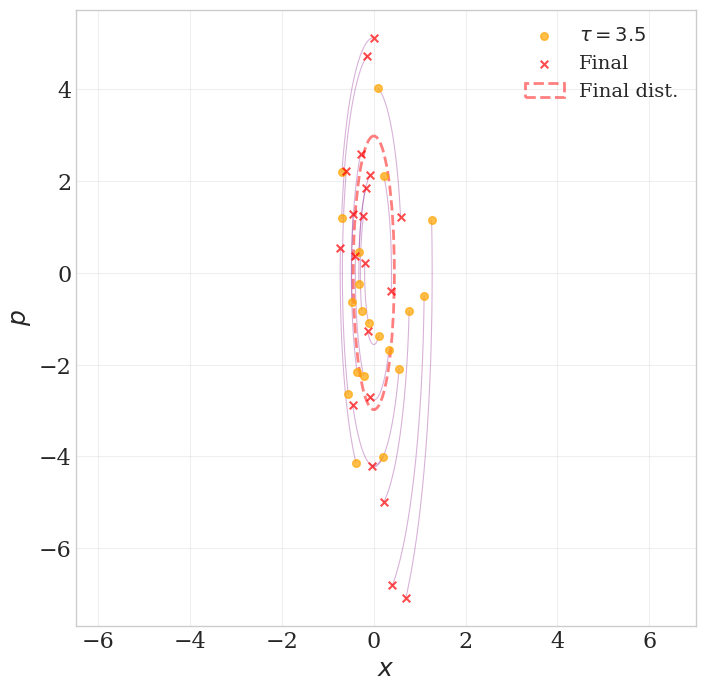

In [17]:
# 2. Phase space trajectories (late time)
fig, ax = plt.subplots(figsize=big_figsize)
tau_late_start = max(int(0.7 * len(taus)), 0)
for i in range(n_particles):
    ax.plot(particle_trajectories[tau_late_start:, i, 0], 
             particle_trajectories[tau_late_start:, i, 1], 
             'purple', alpha=0.3, linewidth=0.8)
ax.scatter(particle_trajectories[tau_late_start, :, 0], particle_trajectories[tau_late_start, :, 1],
           c='orange', s=30, zorder=5, label=rf'$\tau={taus[tau_late_start]:.1f}$', alpha=0.7)
ax.scatter(particle_trajectories[-1, :, 0], particle_trajectories[-1, :, 1],
           c='red', s=30, zorder=5, marker='x', label='Final', alpha=0.7)

# Add distribution ellipse at end
Sigma_final = precision_to_covariance(trajectory[-1])
lambda_f, v_f = np.linalg.eig(Sigma_final)
angle_f = np.arctan2(v_f[1, 0], v_f[0, 0]) * 180 / np.pi
ell_f = Ellipse((0, 0), 2*np.sqrt(lambda_f[0]), 2*np.sqrt(lambda_f[1]), 
                angle=angle_f, facecolor='none', edgecolor='red', 
                linewidth=2, linestyle='--', alpha=0.5, label='Final dist.')
ax.add_patch(ell_f)

ax.set_xlabel('$x$')
ax.set_ylabel('$p$')
print(rf'Phase Space: Late $\tau$ ($\tau$ > {taus[tau_late_start]:.1f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.savefig('./diagrams/fig-particle-trajectories_phase-space-trajectories-late.pdf', 
            bbox_inches='tight', dpi=300)


Full Phase Space Evolution


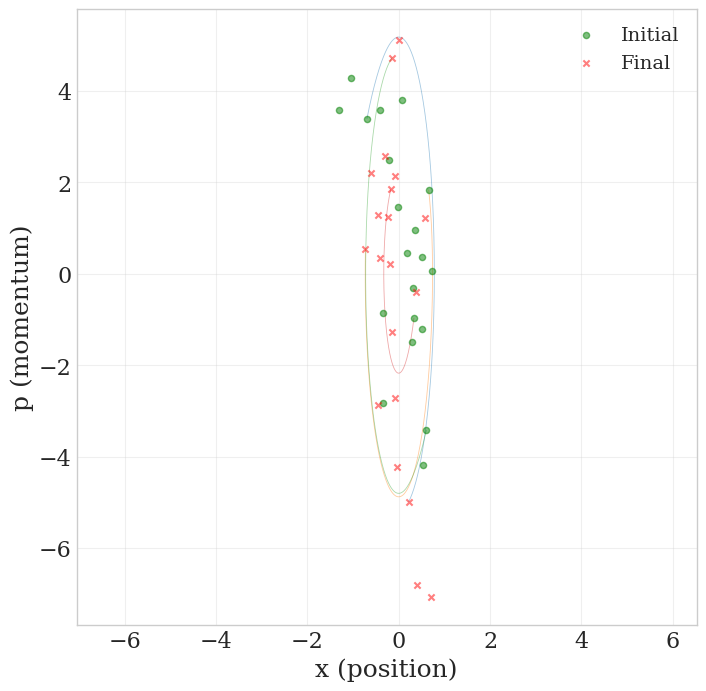

In [18]:
# 3. Full phase space evolution
fig, ax = plt.subplots(figsize=big_figsize)
# Plot every 5th particle to avoid clutter
for i in range(0, n_particles, 5):
    ax.plot(particle_trajectories[:, i, 0], 
             particle_trajectories[:, i, 1], 
             alpha=0.4, linewidth=0.6)
ax.scatter(particle_trajectories[0, :, 0], particle_trajectories[0, :, 1], 
           c='green', s=20, zorder=5, alpha=0.5, label='Initial')
ax.scatter(particle_trajectories[-1, :, 0], particle_trajectories[-1, :, 1],
           c='red', s=20, zorder=5, marker='x', alpha=0.5, label='Final')
ax.set_xlabel('x (position)')
ax.set_ylabel('p (momentum)')
print('Full Phase Space Evolution')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.savefig('./diagrams/fig-particle-trajectories_full-phase-space-evolution.pdf', 
            bbox_inches='tight', dpi=300)


Position vs $\tau$ (5 particles)


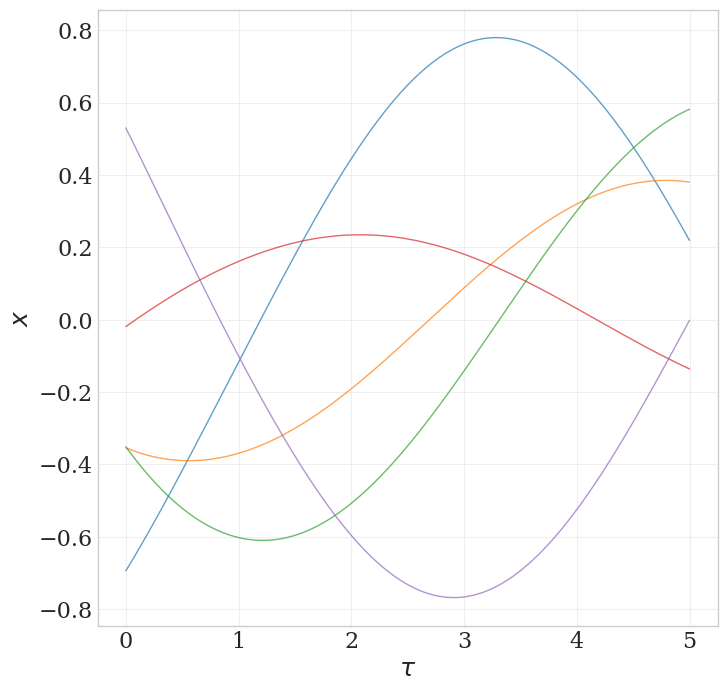

In [19]:
# 4. Individual particle position vs time (sample)
fig, ax = plt.subplots(figsize=big_figsize)
for i in range(min(5, n_particles)):
    ax.plot(taus, particle_trajectories[:, i, 0], alpha=0.7, linewidth=1)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('$x$')
print(r'Position vs $\tau$ (5 particles)')
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-particle-trajectories_individual-particle-position.pdf', 
            bbox_inches='tight', dpi=300)


Momentum vs $\tau$ (5 particles)


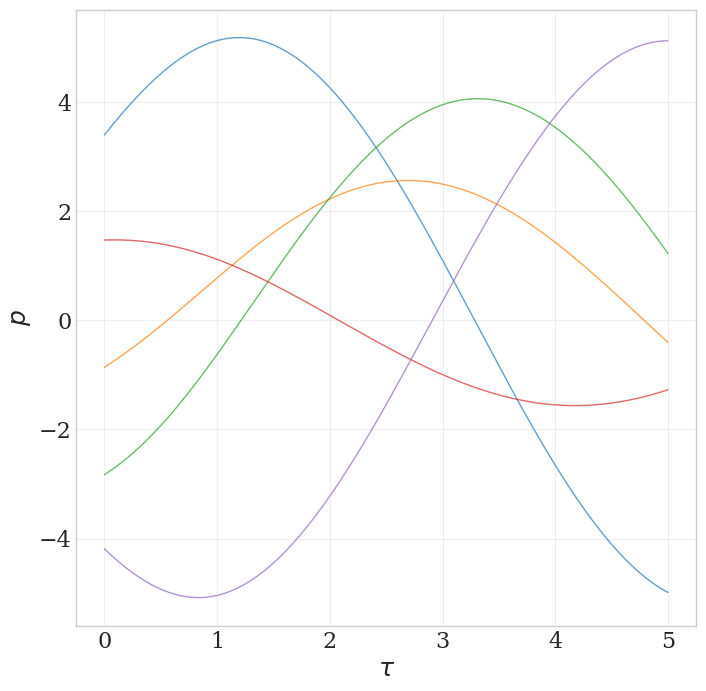

In [20]:
# 5. Individual particle momentum vs time (sample)
fig, ax = plt.subplots(figsize=big_figsize)
for i in range(min(5, n_particles)):
    ax.plot(taus, particle_trajectories[:, i, 1], alpha=0.7, linewidth=1)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('$p$')
print(r'Momentum vs $\tau$ (5 particles)')
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-particle-trajectories_individual-particle-momenta.pdf', 
            bbox_inches='tight', dpi=300)


Effective Hamiltonian Parameters


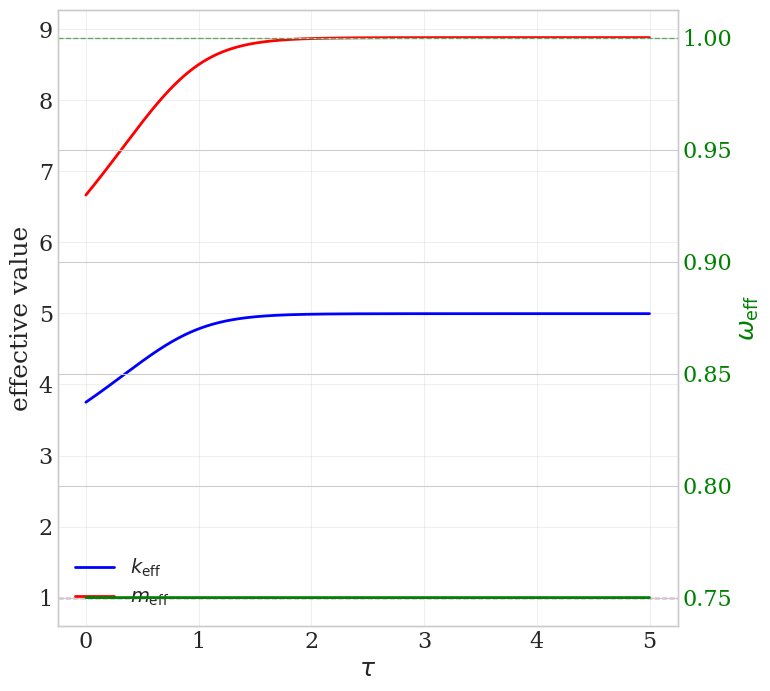

In [21]:
# 6. Effective parameters evolution
fig, ax = plt.subplots(figsize=big_figsize)
ax_twin = ax.twinx()
ax.plot(taus, k_eff_traj, 'b-', linewidth=2, label=r'$k_{\text{eff}}$')
ax.plot(taus, m_eff_traj, 'r-', linewidth=2, label=r'$m_{\text{eff}}$')
ax.axhline(k, color='b', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(m, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('effective value')
ax.legend()
ax.grid(True, alpha=0.3)

ax_twin.plot(taus, omega_traj, 'g-', linewidth=2, label=r'$\omega_{\text{eff}}$')
ax_twin.axhline(np.sqrt(k/m), color='g', linestyle='--', linewidth=1, alpha=0.5)
ax_twin.set_ylabel(r'$\omega_{\text{eff}}$', color='g')
ax_twin.tick_params(axis='y', labelcolor='g')
ax.legend()
print('Effective Hamiltonian Parameters')
plt.savefig('./diagrams/fig-particle-trajectories_effective-parameters-evolution.pdf', 
            bbox_inches='tight', dpi=300)


energy distribution


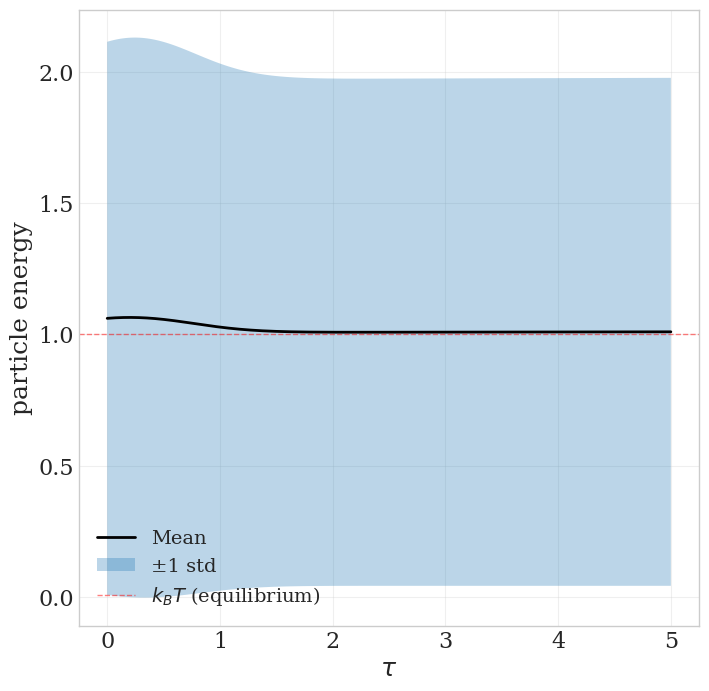

In [22]:
# 7. Particle energies
fig, ax = plt.subplots(figsize=big_figsize)
mean_energy = particle_energies.mean(axis=1)
std_energy = particle_energies.std(axis=1)
ax.plot(taus, mean_energy, 'k-', linewidth=2, label='Mean')
ax.fill_between(taus, mean_energy - std_energy, mean_energy + std_energy,
                 alpha=0.3, label='±1 std')
ax.axhline(k_B * T, color='r', linestyle='--', linewidth=1, 
            alpha=0.5, label=r'$k_B T$ (equilibrium)')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('particle energy')
print('energy distribution')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-particle-trajectories_particle-energies.pdf', 
            bbox_inches='tight', dpi=300)

Energy Distribution: Initial vs Final


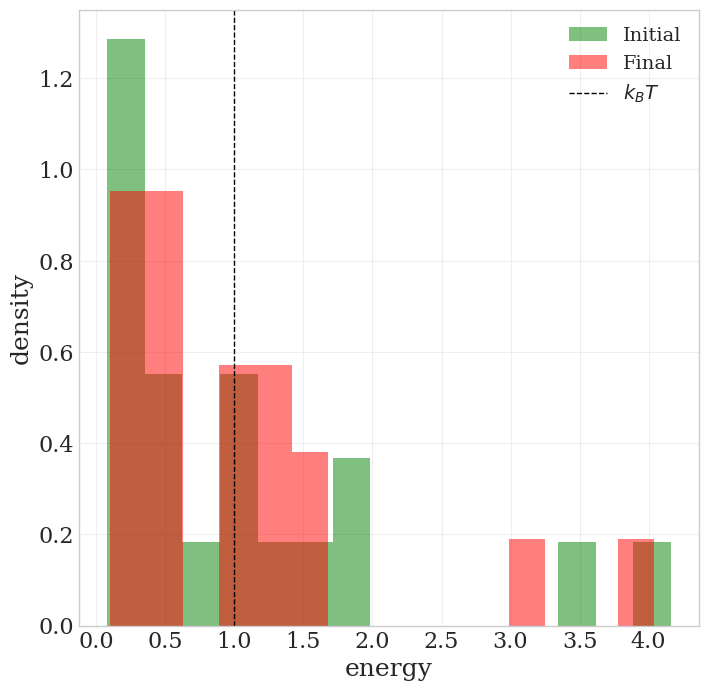

In [23]:
# 8. Energy histogram (initial vs final)
fig, ax = plt.subplots(figsize=big_figsize)
ax.hist(particle_energies[0, :], bins=15, alpha=0.5, label='Initial', color='green', density=True)
ax.hist(particle_energies[-1, :], bins=15, alpha=0.5, label='Final', color='red', density=True)
ax.axvline(k_B * T, color='k', linestyle='--', linewidth=1, label=r'$k_B T$')
ax.set_xlabel('energy')
ax.set_ylabel('density')
print('Energy Distribution: Initial vs Final')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-particle-trajectories_energy-histogram.pdf', 
            bbox_inches='tight', dpi=300)


Particle Statistics vs Distribution


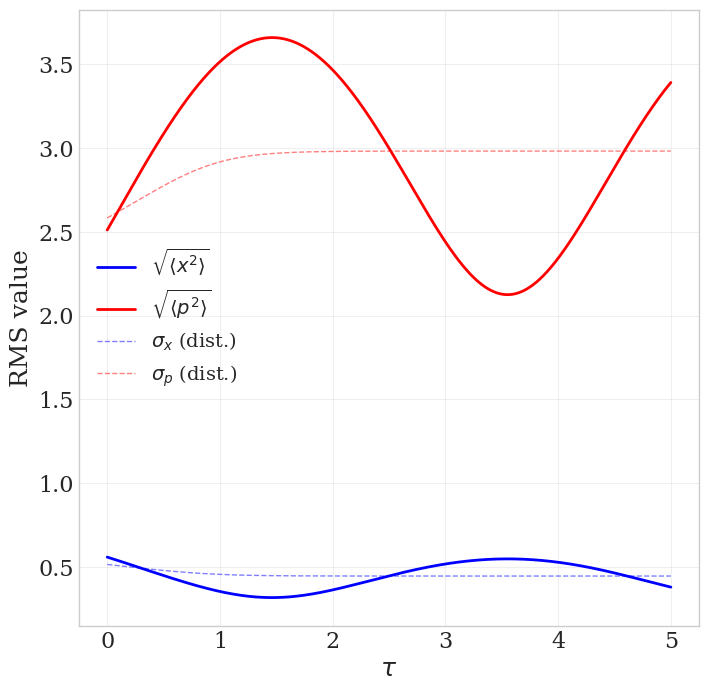

In [24]:
# 9. RMS position and momentum
fig, ax = plt.subplots(figsize=big_figsize)
rms_x = np.sqrt((particle_trajectories[:, :, 0]**2).mean(axis=1))
rms_p = np.sqrt((particle_trajectories[:, :, 1]**2).mean(axis=1))
ax.plot(taus, rms_x, 'b-', linewidth=2, label=r'$\sqrt{\langle x^2 \rangle}$')
ax.plot(taus, rms_p, 'r-', linewidth=2, label=r'$\sqrt{\langle p^2 \rangle}$')
ax.plot(taus, np.sqrt(sigma_x_traj), 'b--', linewidth=1, alpha=0.5, label=r'$\sigma_x$ (dist.)')
ax.plot(taus, np.sqrt(sigma_p_traj), 'r--', linewidth=1, alpha=0.5, label=r'$\sigma_p$ (dist.)')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('RMS value')
print('Particle Statistics vs Distribution')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-particle-trajectories_rms-position-and-momentum.pdf', 
            bbox_inches='tight', dpi=300)


In [25]:
# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Initial energy: {particle_energies[0, :].mean():.3f} ± {particle_energies[0, :].std():.3f}")
print(f"Final energy:   {particle_energies[-1, :].mean():.3f} ± {particle_energies[-1, :].std():.3f}")
print(f"Equilibrium:    {k_B * T:.3f}")
print(f"\nInitial ω: {omega_traj[0]:.3f}, Final ω: {omega_traj[-1]:.3f}, Equilibrium ω: {np.sqrt(k/m):.3f}")
print(f"Frequency change: {100*(omega_traj[-1]/omega_traj[0] - 1):.1f}%")


=== Summary Statistics ===
Initial energy: 1.061 ± 1.053
Final energy:   1.010 ± 0.967
Equilibrium:    1.000

Initial ω: 0.750, Final ω: 0.750, Equilibrium ω: 1.000
Frequency change: 0.0%


In [26]:
"""
Ensemble Measurements: Perceiving the Redistribution
=====================================================

Shows how the x ↔ p energy redistribution is perceived through
ensemble statistics, despite individual particles maintaining
constant oscillation frequency.
"""

import numpy as np
import matplotlib.pyplot as plt

print("\n=== Ensemble Statistics Analysis ===")

# Select key time snapshots
n_snapshots = 5
snapshot_indices = np.linspace(0, len(taus)-1, n_snapshots, dtype=int)
snapshot_taus = taus[snapshot_indices]

print(f"Analyzing {n_snapshots} snapshots at taus: {snapshot_taus}")


=== Ensemble Statistics Analysis ===
Analyzing 5 snapshots at taus: [0.    1.249 2.499 3.749 4.999]


✓ Saved: fig-ensemble_constraint-product.pdf


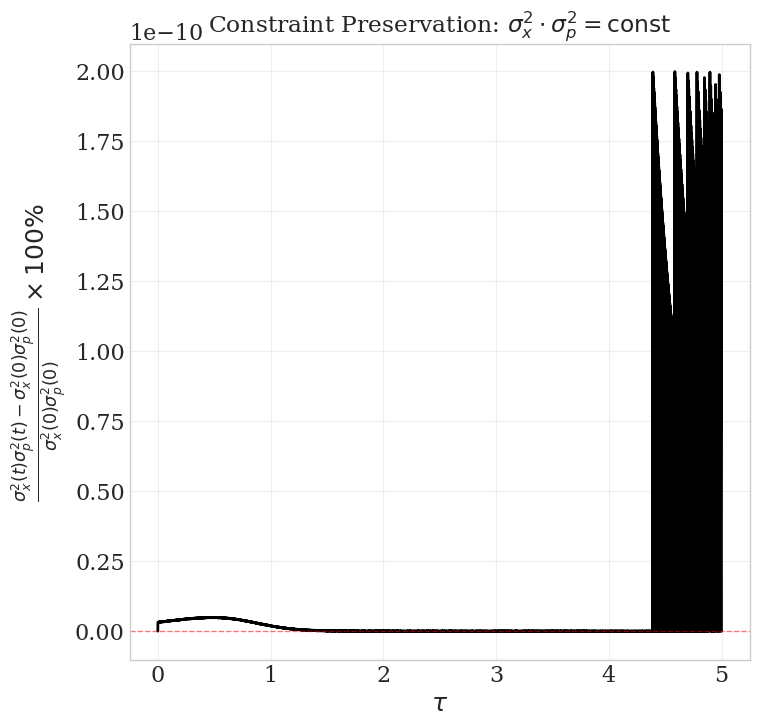

In [27]:
# Panel 1: Constraint product σ_x² · σ_p² (should be constant)
fig, ax = plt.subplots(figsize=big_figsize)
product = sigma_x_traj * sigma_p_traj
product_relative_variation = (product - product[0]) / product[0]

ax.plot(taus, product_relative_variation * 100, 'k-', linewidth=2)
ax.axhline(0, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\frac{\sigma_x^2(t) \sigma_p^2(t) - \sigma_x^2(0) \sigma_p^2(0)}{\sigma_x^2(0) \sigma_p^2(0)} \times 100\%$')
ax.set_title(r'Constraint Preservation: $\sigma_x^2 \cdot \sigma_p^2 = \mathrm{const}$')
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-ensemble_constraint-product.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_constraint-product.pdf")
plt.show()

✓ Saved: fig-ensemble_equipartition-ratio.pdf


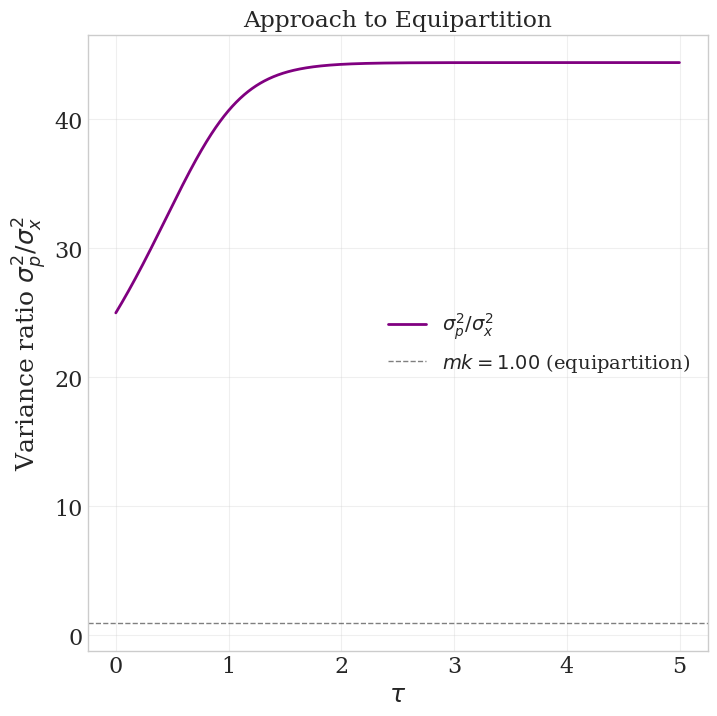

In [28]:
# Panel 2: Equipartition ratio σ_p²/σ_x² → mk
fig, ax = plt.subplots(figsize=big_figsize)
ratio = sigma_p_traj / sigma_x_traj
target_ratio = m * k

ax.plot(taus, ratio, 'purple', linewidth=2, label=r'$\sigma_p^2 / \sigma_x^2$')
ax.axhline(target_ratio, color='k', linestyle='--', linewidth=1, alpha=0.5, 
           label=f'$mk = {target_ratio:.2f}$ (equipartition)')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'Variance ratio $\sigma_p^2 / \sigma_x^2$')
ax.set_title('Approach to Equipartition')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-ensemble_equipartition-ratio.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_equipartition-ratio.pdf")
plt.show()

✓ Saved: fig-ensemble_variance-tradeoff.pdf


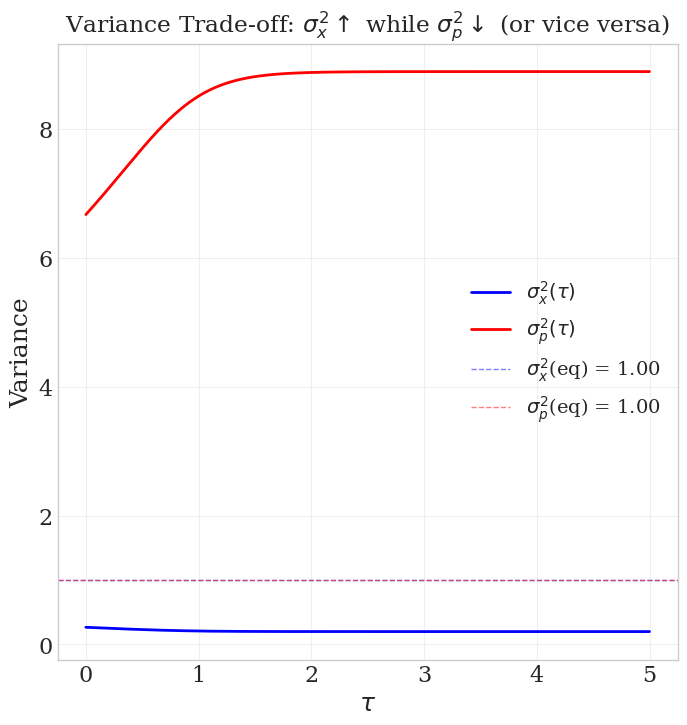

In [29]:
# Panel 3: Individual variances trading off
fig, ax = plt.subplots(figsize=big_figsize)
ax.plot(taus, sigma_x_traj, 'b-', linewidth=2, label=r'$\sigma_x^2(\tau)$')
ax.plot(taus, sigma_p_traj, 'r-', linewidth=2, label=r'$\sigma_p^2(\tau)$')
ax.axhline(sigma_x_eq, color='b', linestyle='--', linewidth=1, alpha=0.5, 
           label=f'$\\sigma_x^2$(eq) = {sigma_x_eq:.2f}')
ax.axhline(sigma_p_eq, color='r', linestyle='--', linewidth=1, alpha=0.5,
           label=f'$\\sigma_p^2$(eq) = {sigma_p_eq:.2f}')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Variance')
ax.set_title(r'Variance Trade-off: $\sigma_x^2 \uparrow$ while $\sigma_p^2 \downarrow$ (or vice versa)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-ensemble_variance-tradeoff.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_variance-tradeoff.pdf")
plt.show()

✓ Saved: fig-ensemble_temperature-equilibration.pdf


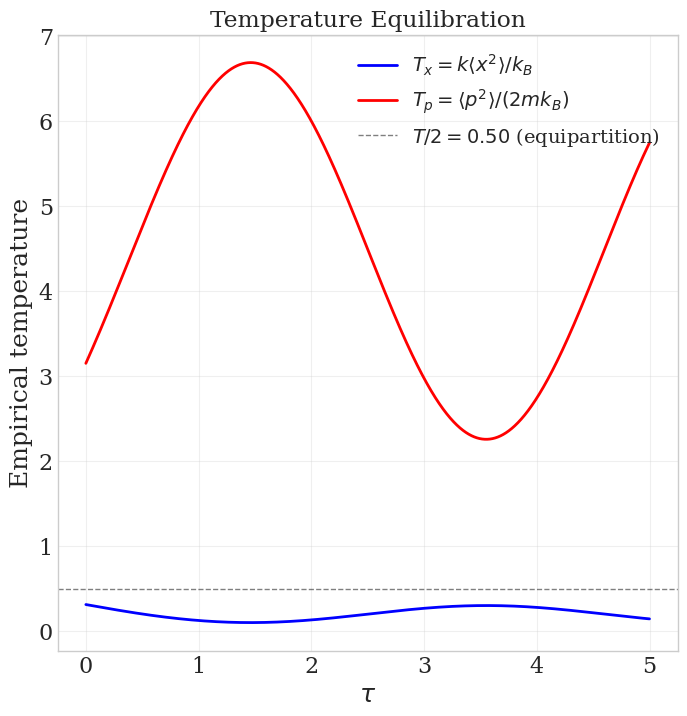

In [30]:
# Panel 4: Empirical temperatures from particles
fig, ax = plt.subplots(figsize=big_figsize)
# T_x = k⟨x²⟩/k_B, T_p = ⟨p²⟩/(2m k_B)
# For our units with k_B = 1:
T_x_empirical = k * (particle_trajectories[:, :, 0]**2).mean(axis=1)
T_p_empirical = (particle_trajectories[:, :, 1]**2).mean(axis=1) / (2 * m)

ax.plot(taus, T_x_empirical, 'b-', linewidth=2, label=r'$T_x = k\langle x^2 \rangle / k_B$')
ax.plot(taus, T_p_empirical, 'r-', linewidth=2, label=r'$T_p = \langle p^2 \rangle / (2m k_B)$')
ax.axhline(T / 2, color='k', linestyle='--', linewidth=1, alpha=0.5,
           label=f'$T/2 = {T/2:.2f}$ (equipartition)')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Empirical temperature')
ax.set_title('Temperature Equilibration')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-ensemble_temperature-equilibration.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_temperature-equilibration.pdf")
plt.show()

✓ Saved: fig-ensemble_position-histograms.pdf


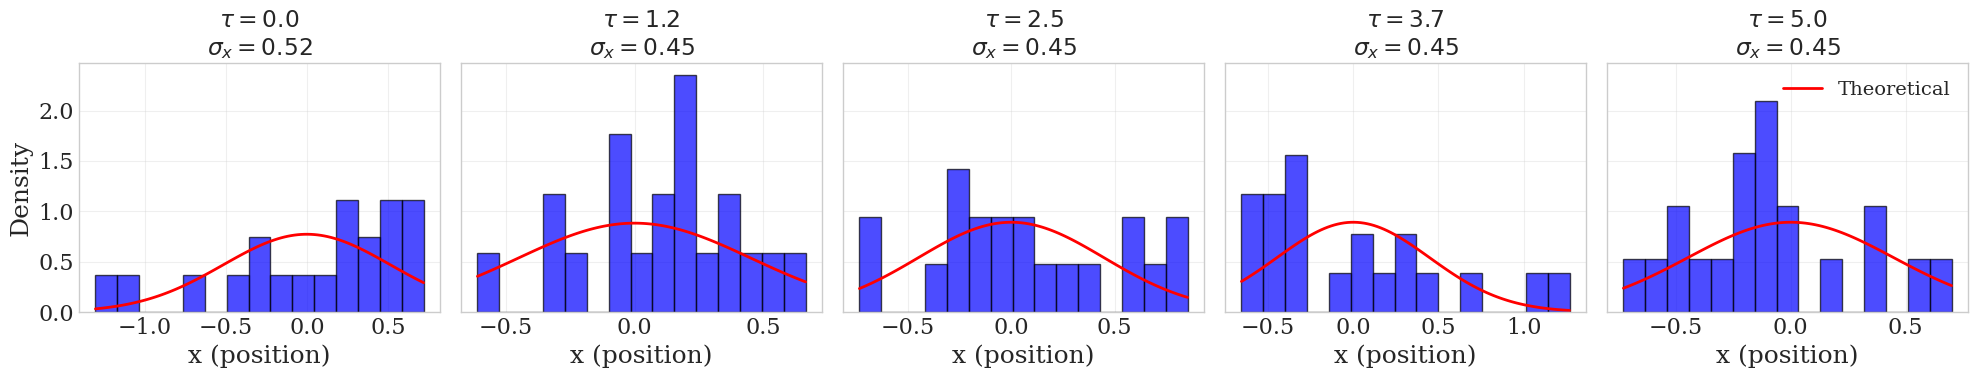

In [31]:
# Panel 5: Position histograms at different taus
fig, axes = plt.subplots(1, n_snapshots, figsize=(4*n_snapshots, 4), sharey=True)
for i, (idx, t) in enumerate(zip(snapshot_indices, snapshot_taus)):
    x_snapshot = particle_trajectories[idx, :, 0]
    axes[i].hist(x_snapshot, bins=15, density=True, alpha=0.7, color='blue', edgecolor='black')
    
    # Overlay theoretical Gaussian
    x_range = np.linspace(x_snapshot.min(), x_snapshot.max(), 100)
    sigma_x = np.sqrt(sigma_x_traj[idx])
    theoretical = (1 / (sigma_x * np.sqrt(2*np.pi))) * np.exp(-x_range**2 / (2*sigma_x**2))
    axes[i].plot(x_range, theoretical, 'r-', linewidth=2, label='Theoretical')
    
    axes[i].set_xlabel('x (position)')
    axes[i].set_title(f'$\\tau = {taus[idx]:.1f}$\n$\\sigma_x = {sigma_x:.2f}$')
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_ylabel('Density')
    if i == n_snapshots - 1:
        axes[i].legend()

plt.tight_layout()
plt.savefig('./diagrams/fig-ensemble_position-histograms.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_position-histograms.pdf")
plt.show()

✓ Saved: fig-ensemble_momentum-histograms.pdf


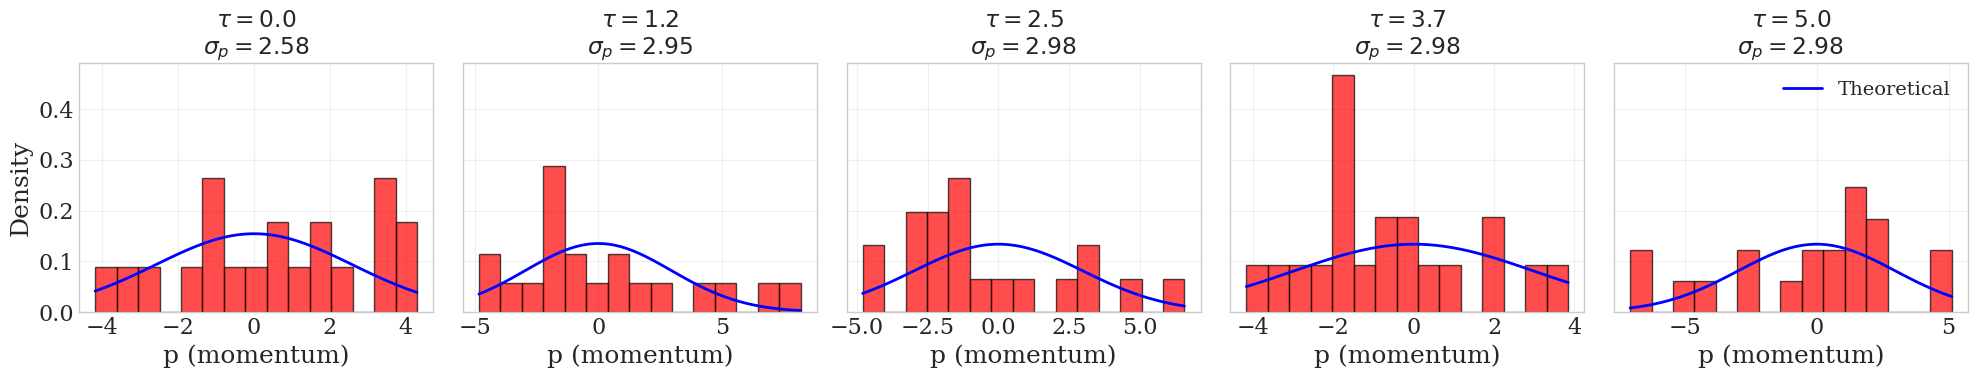

In [32]:
# Panel 6: Momentum histograms at different taus
fig, axes = plt.subplots(1, n_snapshots, figsize=(4*n_snapshots, 4), sharey=True)
for i, (idx, t) in enumerate(zip(snapshot_indices, snapshot_taus)):
    p_snapshot = particle_trajectories[idx, :, 1]
    axes[i].hist(p_snapshot, bins=15, density=True, alpha=0.7, color='red', edgecolor='black')
    
    # Overlay theoretical Gaussian
    p_range = np.linspace(p_snapshot.min(), p_snapshot.max(), 100)
    sigma_p = np.sqrt(sigma_p_traj[idx])
    theoretical = (1 / (sigma_p * np.sqrt(2*np.pi))) * np.exp(-p_range**2 / (2*sigma_p**2))
    axes[i].plot(p_range, theoretical, 'b-', linewidth=2, label='Theoretical')
    
    axes[i].set_xlabel('p (momentum)')
    axes[i].set_title(f'$\\tau = {taus[idx]:.1f}$\n$\\sigma_p = {sigma_p:.2f}$')
    axes[i].grid(True, alpha=0.3)
    if i == 0:
        axes[i].set_ylabel('Density')
    if i == n_snapshots - 1:
        axes[i].legend()

plt.tight_layout()
plt.savefig('./diagrams/fig-ensemble_momentum-histograms.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_momentum-histograms.pdf")
plt.show()

✓ Saved: fig-ensemble_phase-space-snapshots.pdf


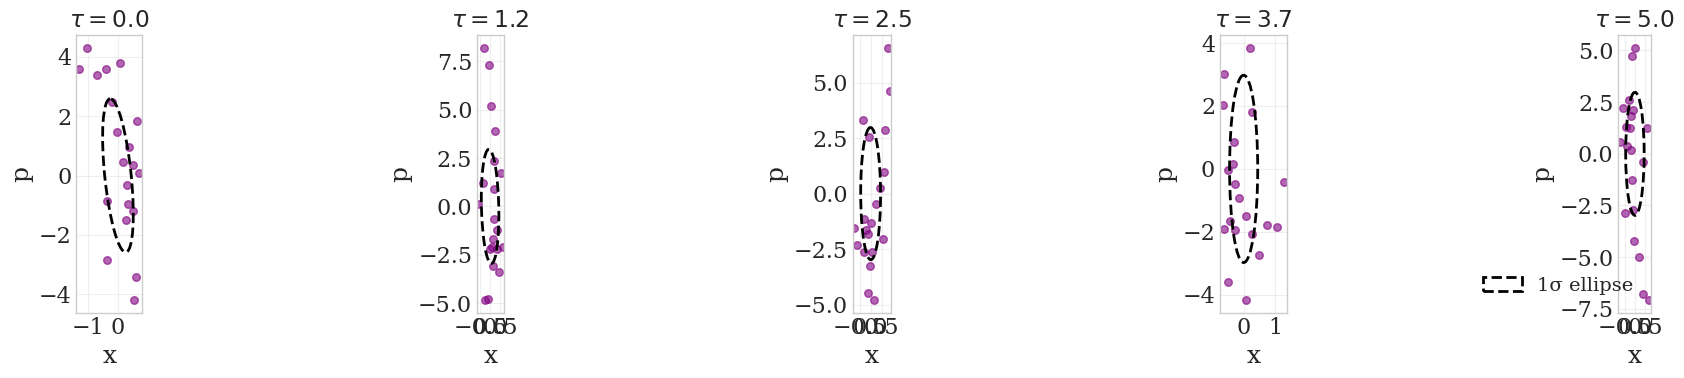

In [33]:
# Panel 7: Phase space snapshots with ellipses
fig, axes = plt.subplots(1, n_snapshots, figsize=(4*n_snapshots, 4))
for i, (idx, t) in enumerate(zip(snapshot_indices, snapshot_taus)):
    x_snapshot = particle_trajectories[idx, :, 0]
    p_snapshot = particle_trajectories[idx, :, 1]
    
    axes[i].scatter(x_snapshot, p_snapshot, alpha=0.6, s=30, color='purple')
    
    # Add distribution ellipse
    Sigma_snap = precision_to_covariance(trajectory[idx])
    lambda_snap, v_snap = np.linalg.eig(Sigma_snap)
    angle_snap = np.arctan2(v_snap[1, 0], v_snap[0, 0]) * 180 / np.pi
    
    from matplotlib.patches import Ellipse
    ell = Ellipse((0, 0), 2*np.sqrt(lambda_snap[0]), 2*np.sqrt(lambda_snap[1]),
                  angle=angle_snap, facecolor='none', edgecolor='black',
                  linewidth=2, linestyle='--', label='1σ ellipse')
    axes[i].add_patch(ell)
    
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('p')
    axes[i].set_title(f'$\\tau = {taus[idx]:.1f}$')
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].grid(True, alpha=0.3)
    if i == n_snapshots - 1:
        axes[i].legend()

plt.tight_layout()
plt.savefig('./diagrams/fig-ensemble_phase-space-snapshots.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_phase-space-snapshots.pdf")
plt.show()

✓ Saved: fig-ensemble_entropy-tradeoff.pdf


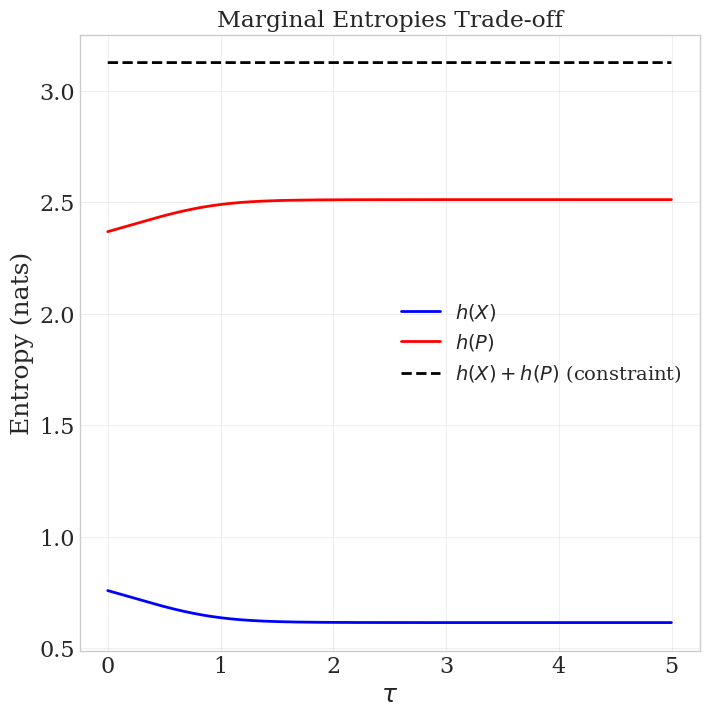

In [34]:
# Panel 8: Marginal entropies trading off
fig, ax = plt.subplots(figsize=big_figsize)
h_X_traj = np.array([marginal_entropies(theta)[0] for theta in trajectory])
h_P_traj = np.array([marginal_entropies(theta)[1] for theta in trajectory])
h_total_traj = h_X_traj + h_P_traj

ax.plot(taus, h_X_traj, 'b-', linewidth=2, label=r'$h(X)$')
ax.plot(taus, h_P_traj, 'r-', linewidth=2, label=r'$h(P)$')
ax.plot(taus, h_total_traj, 'k--', linewidth=2, label=r'$h(X) + h(P)$ (constraint)')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Entropy (nats)')
ax.set_title('Marginal Entropies Trade-off')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('./diagrams/fig-ensemble_entropy-tradeoff.pdf', bbox_inches='tight', dpi=300)
print("✓ Saved: fig-ensemble_entropy-tradeoff.pdf")
plt.show()

In [35]:
# Print of summary
print("\n=== Summary Redistribution ===")
print(f"Initial state:")
print(f"  σ_x² = {sigma_x_traj[0]:.3f}, σ_p² = {sigma_p_traj[0]:.3f}")
print(f"  Ratio σ_p²/σ_x² = {sigma_p_traj[0]/sigma_x_traj[0]:.3f} (target: {m*k:.3f})")
print(f"  Product σ_x²·σ_p² = {product[0]:.3f}")
print(f"  h(X) = {h_X_traj[0]:.3f}, h(P) = {h_P_traj[0]:.3f}")
print(f"\nFinal state:")
print(f"  σ_x² = {sigma_x_traj[-1]:.3f}, σ_p² = {sigma_p_traj[-1]:.3f}")
print(f"  Ratio σ_p²/σ_x² = {sigma_p_traj[-1]/sigma_x_traj[-1]:.3f} (target: {m*k:.3f})")
print(f"  Product σ_x²·σ_p² = {product[-1]:.3f}")
print(f"  h(X) = {h_X_traj[-1]:.3f}, h(P) = {h_P_traj[-1]:.3f}")
print(f"\nConstraint preservation:")
print(f"  Product variation: {product_relative_variation[-1]*100:.6f}%")
print(f"  Total entropy variation: {(h_total_traj[-1] - h_total_traj[0]):.6e} nats")
print(f"\nEquipartition achieved:")
print(f"  Final ratio / Target ratio = {(sigma_p_traj[-1]/sigma_x_traj[-1])/(m*k):.6f}")


=== Summary Redistribution ===
Initial state:
  σ_x² = 0.267, σ_p² = 6.667
  Ratio σ_p²/σ_x² = 25.000 (target: 1.000)
  Product σ_x²·σ_p² = 1.778
  h(X) = 0.758, h(P) = 2.367

Final state:
  σ_x² = 0.200, σ_p² = 8.884
  Ratio σ_p²/σ_x² = 44.396 (target: 1.000)
  Product σ_x²·σ_p² = 1.778
  h(X) = 0.614, h(P) = 2.511

Constraint preservation:
  Product variation: -0.000000%
  Total entropy variation: 0.000000e+00 nats

Equipartition achieved:
  Final ratio / Target ratio = 44.395843
